# Consumer Price Index - UK
Data source: https://data.nasdaq.com/data/RATEINF/CPI_GBR-consumer-price-index-uk

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles statistical models.
import os
import warnings # This is a library that handles warnings.
import gc

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [3]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

In [5]:
# Configure API key 

quandl.ApiConfig.api_key = 'fN64KyU4KesgZcboJsMQ'

In [30]:
# Importing the Consumer Price Index - UK.

df = quandl.get('RATEINF/CPI_GBR')

In [31]:
df.head()

,Value
Date,
1988-01-31,48.395
1988-02-29,48.551
1988-03-31,48.717
1988-04-30,49.280
1988-05-31,49.529


In [32]:
df.tail()

,Value
Date,
2022-10-31,126.199
2022-11-30,126.694
2022-12-31,127.164
2023-01-31,126.447
2023-02-28,127.891


#Dataset contains monthly observation from 1988-2023.

In [33]:
df.shape

(422, 1)

In [34]:
df.columns

Index(['Value'], dtype='object')

In [35]:
type(df)

pandas.core.frame.DataFrame

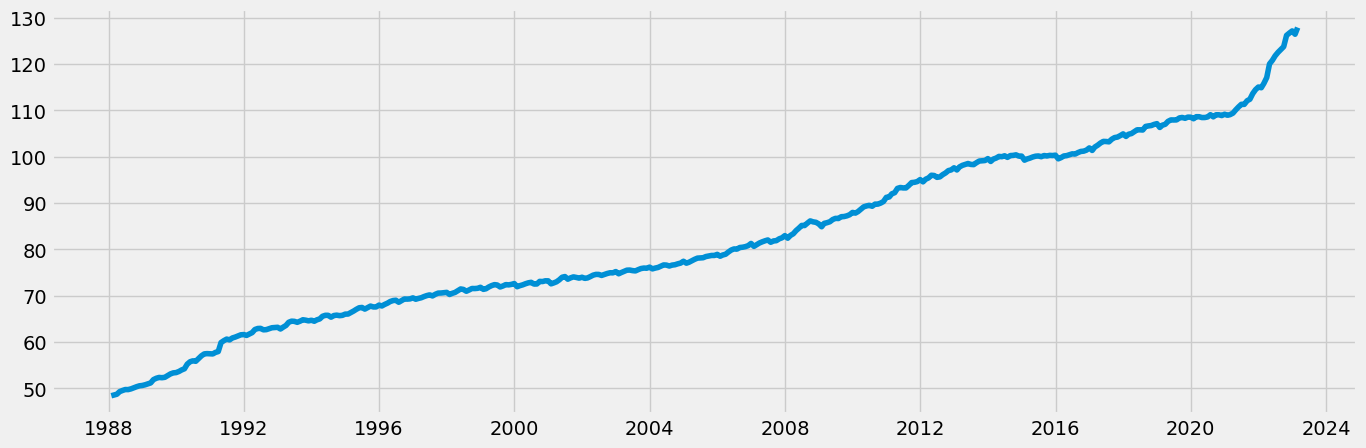

In [36]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df)

In [ ]:
#2. Subsetting, wrangling, and cleaning time-series data

In [ ]:
#Subsetting from 20-year period, from 2000 onwards. Also. data does not contain any forecasting.

In [37]:
# Reset index so that you can use the "Date" column as a filter

df_2 = df.reset_index()

In [38]:
df_2.head()

,Date,Value
0,1988-01-31,48.395
1,1988-02-29,48.551
2,1988-03-31,48.717
3,1988-04-30,49.280
4,1988-05-31,49.529


In [39]:
df_sub = df_2.loc[(df_2['Date'] >= '2000-01-01')]

In [40]:
df_sub.shape

(278, 2)

In [41]:
# Set the "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['Date']) # Create a datetime column from "Date.""
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,Value
datetime,
2000-01-31,71.936
2000-02-29,72.159
2000-03-31,72.338
2000-04-30,72.573
2000-05-31,72.771


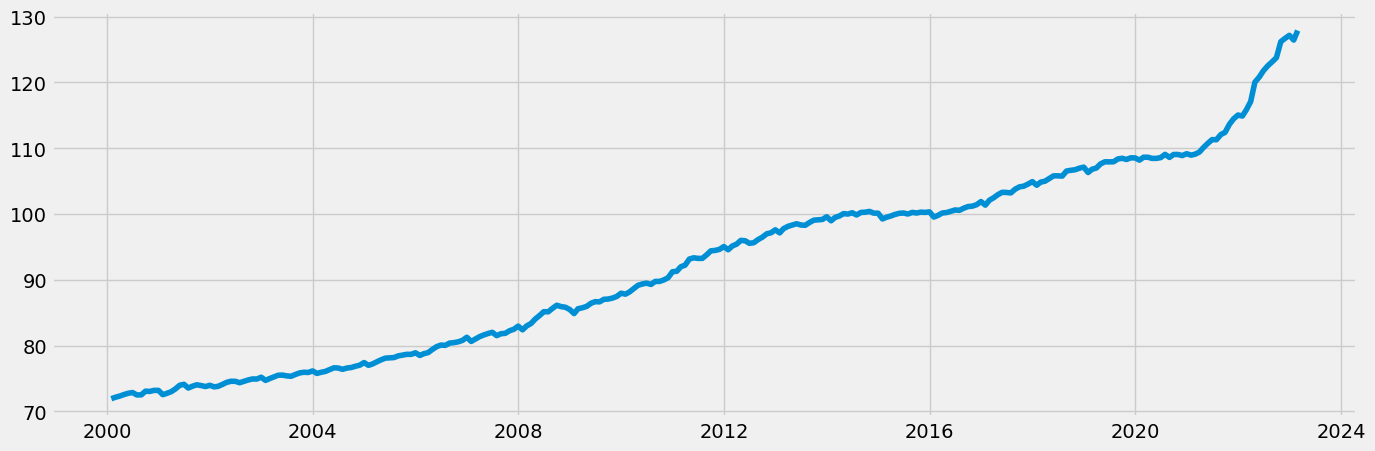

In [42]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_sub)

In [43]:
# Check for missing values 

df_sub.isnull().sum() #No missing values

Value    0
dtype: int64

In [44]:
# Check for duplicates

dups = df_sub.duplicated()
dups.sum()

# No dups

0

In [45]:
df_sub

,Value
datetime,
2000-01-31,71.936
2000-02-29,72.159
2000-03-31,72.338
2000-04-30,72.573
2000-05-31,72.771
...,...
2022-10-31,126.199
2022-11-30,126.694
2022-12-31,127.164


In [46]:
df_sub.groupby(['Value']).agg({'Value': 'count'})

,Value
Value,
71.936,1
72.159,1
72.338,1
72.508,1
72.526,1
...,...
126.199,1
126.447,1
126.694,1


#3. Time-series analysis: decomposition

Looking at the data pattern, I would guess that multiplicative model might be more appropriate to capture the non-linear fashion. However, I would like to try both of the model and see the difference.

3.1 Decompotion: Additive Model

In [47]:
# Decompose the time series using an additive model

decomposition_adi = sm.tsa.seasonal_decompose(df_sub, model='additive') 

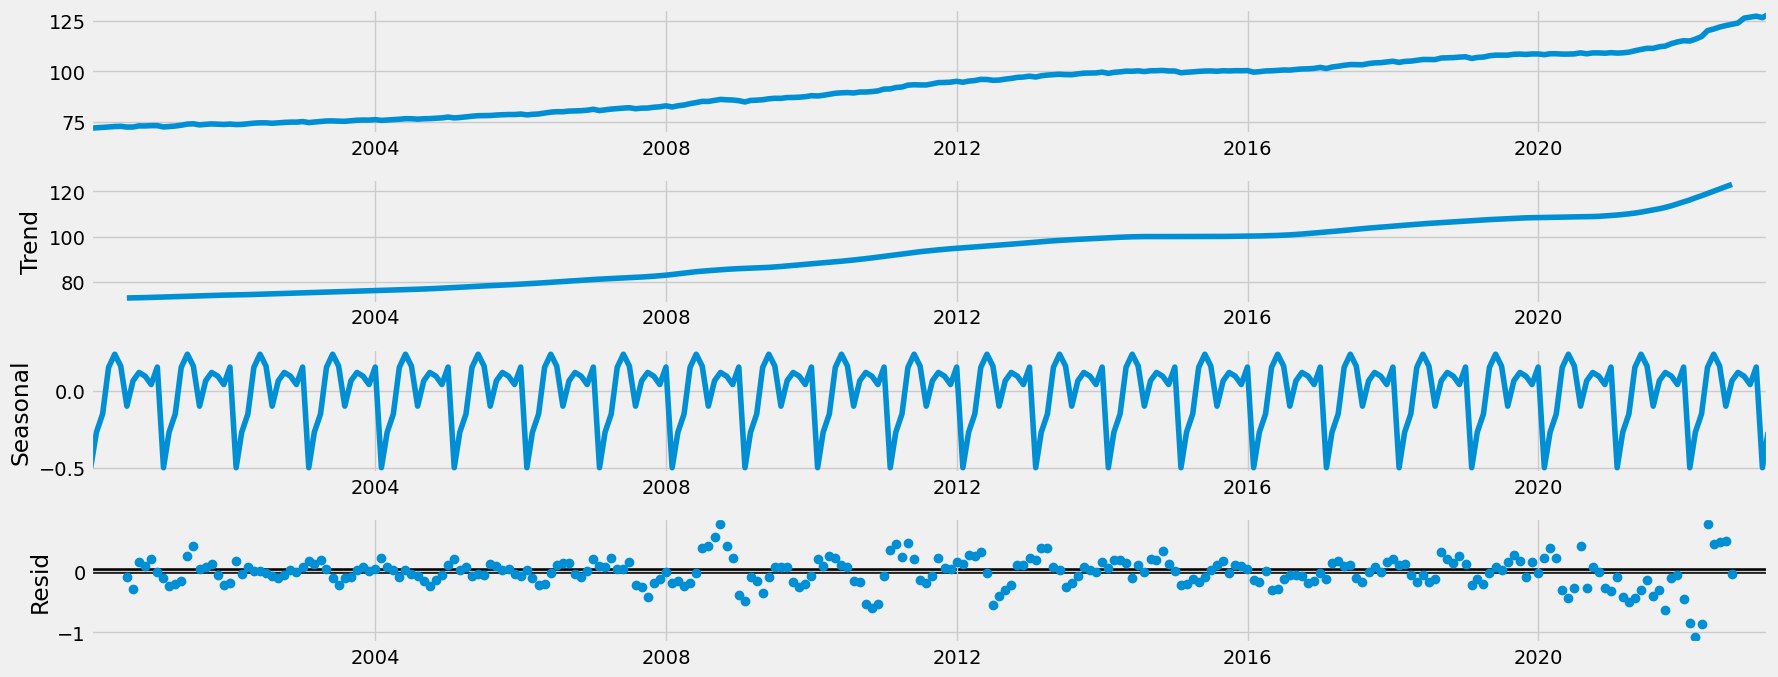

In [48]:
# Plot the separate components

decomposition_adi.plot()
plt.show()

3.2 Decompotion: Multiplicative Model

In [49]:
# Decompose the time series using an multiplicative model

decomposition_multi = sm.tsa.seasonal_decompose(df_sub, model='multiplicative') 

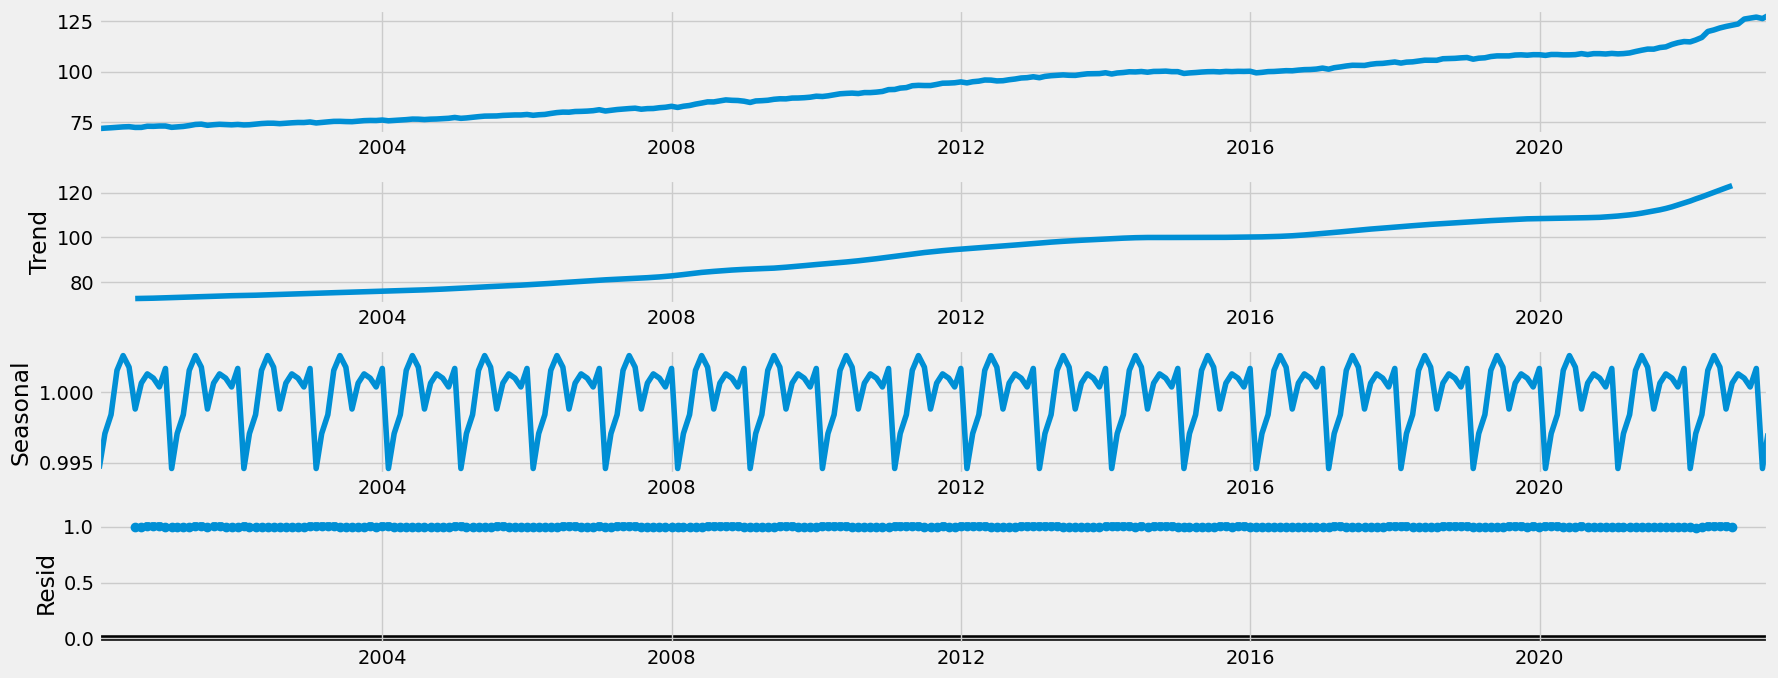

In [50]:
# Plot the separate components

decomposition_multi.plot()
plt.show()

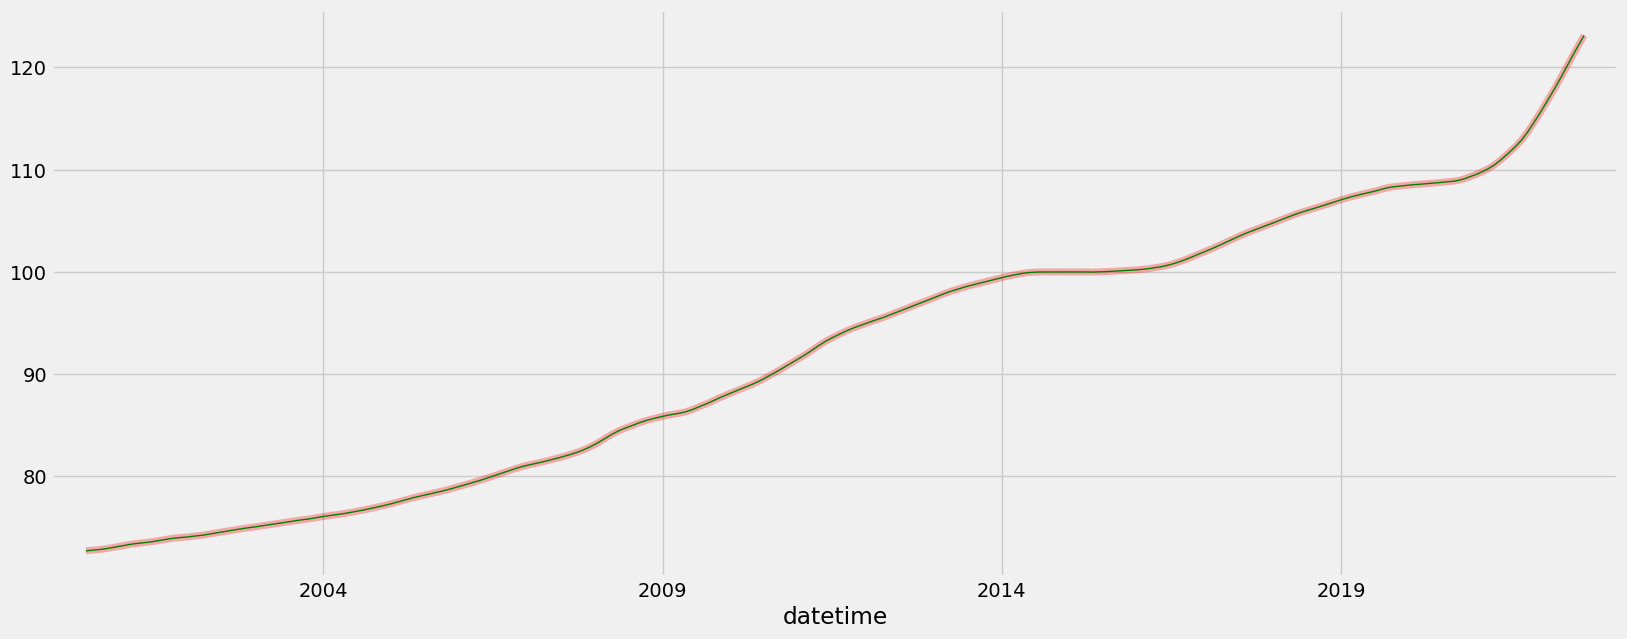

In [51]:
# Evaluating trends component from both models

decomposition_adi.trend.plot(color='red', linewidth=5, alpha=0.3)
decomposition_multi.trend.plot(color='green', linewidth=1)
plt.show()

In [ ]:
Looking at the both plots, the additive and multiplicative model create same pattern of trend and seasonality.However, the residual component from additive model has more spread-out spots, compared to the residual component from multiplicative model that has more constant variance.

4. Testing for stationarity

In [52]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.298225
p-value                          0.996599
Number of Lags Used             14.000000
Number of Observations Used    263.000000
Critical Value (1%)             -3.455461
Critical Value (5%)             -2.872593
Critical Value (10%)            -2.572660
dtype: float64


#If test statistic larger than critical value = can’t reject null hypothesis.
#If test statistic smaller than critical value = can reject null hypothesis

#Using significance level of 5%, the critical Value is -2.872593. While, the test statistic is -0.550861, which shows that it is larger than critical value. This means that the null hypothesis cannot be rejected. In other words, there is a unit root in our data and our data is non-stationary. 

#Using p-value, it also shows the same result. P-value (0.996599) is also larger than 0.05.

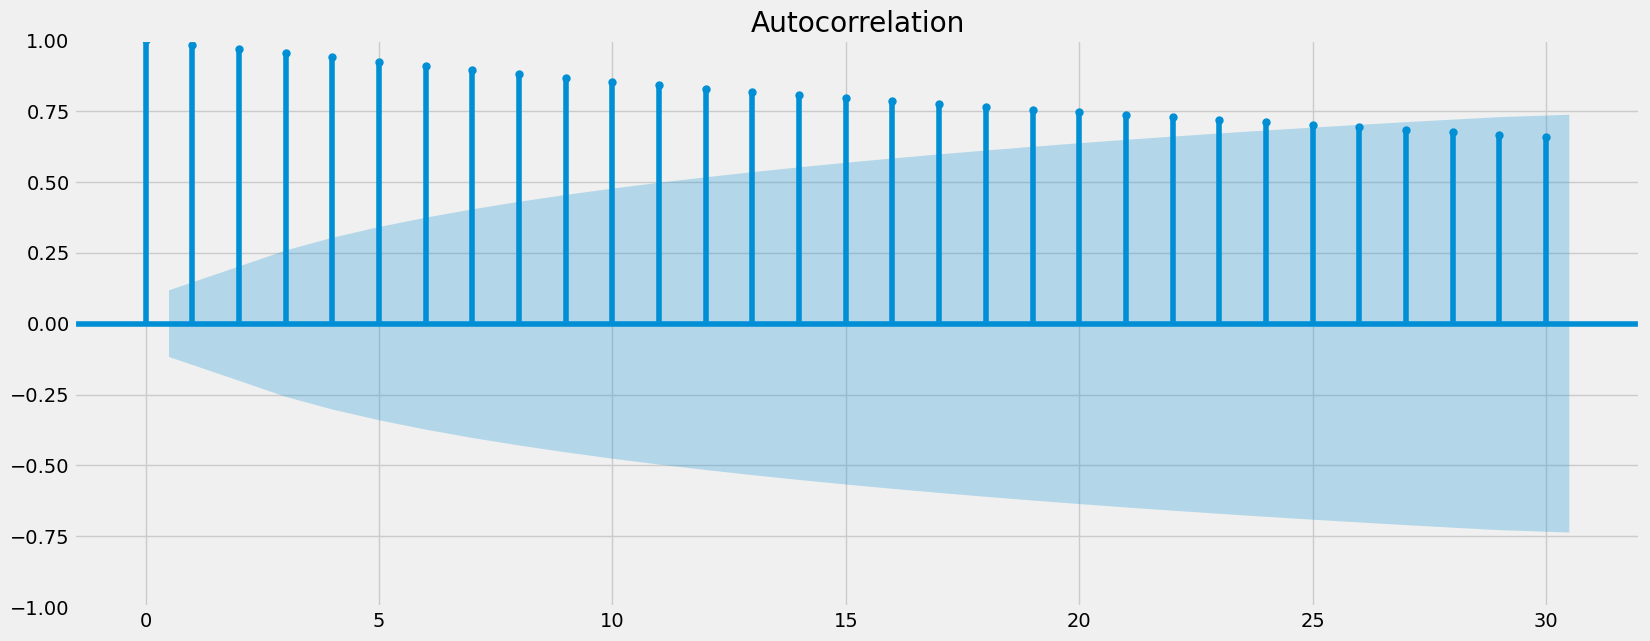

In [53]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_sub, lags=30)
plt.show()

In [55]:
autocorr = acf(df_sub, alpha=0.05)
autocorr 

(array([1.        , 0.98453807, 0.96977362, 0.95425092, 0.93887403,
        0.92350272, 0.90942191, 0.89502647, 0.88076378, 0.86687416,
        0.85345909, 0.84030122, 0.82879709, 0.81731971, 0.80639484,
        0.79528276, 0.78457451, 0.7744134 , 0.7649722 , 0.75520724,
        0.74594688, 0.7366209 , 0.72750255, 0.7186082 , 0.71017381]),
 array([[1.        , 1.        ],
        [0.86698724, 1.1020889 ],
        [0.76826289, 1.17128435],
        [0.69618597, 1.21231588],
        [0.63594982, 1.24179825],
        [0.58273281, 1.26427263],
        [0.53566526, 1.28317856],
        [0.49185075, 1.29820219],
        [0.45100872, 1.31051885],
        [0.41286072, 1.3208876 ],
        [0.37712292, 1.32979526],
        [0.34328383, 1.33731861],
        [0.31252147, 1.34507271],
        [0.28297517, 1.35166425],
        [0.25504603, 1.35774365],
        [0.22787047, 1.36269505],
        [0.20196312, 1.36718589],
        [0.1773809 , 1.3714459 ],
        [0.1542171 , 1.3757273 ],
        [0.1

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. As we can see, most of lags go above the blue edge of the confidence interval. This means we have lags that are significantly correlated with each other.

In [ ]:
5. Stationarizing the Data

In [56]:
df_diff = df_sub - df_sub.shift(1)

In [58]:
df_diff.dropna(inplace = True)# Here, you remove the missing values that came about as a result of the differencing. 
df_diff.head()

,Value
datetime,
2000-02-29,0.223
2000-03-31,0.179
2000-04-30,0.235
2000-05-31,0.198
2000-06-30,0.105


In [59]:
df_diff.columns

Index(['Value'], dtype='object')

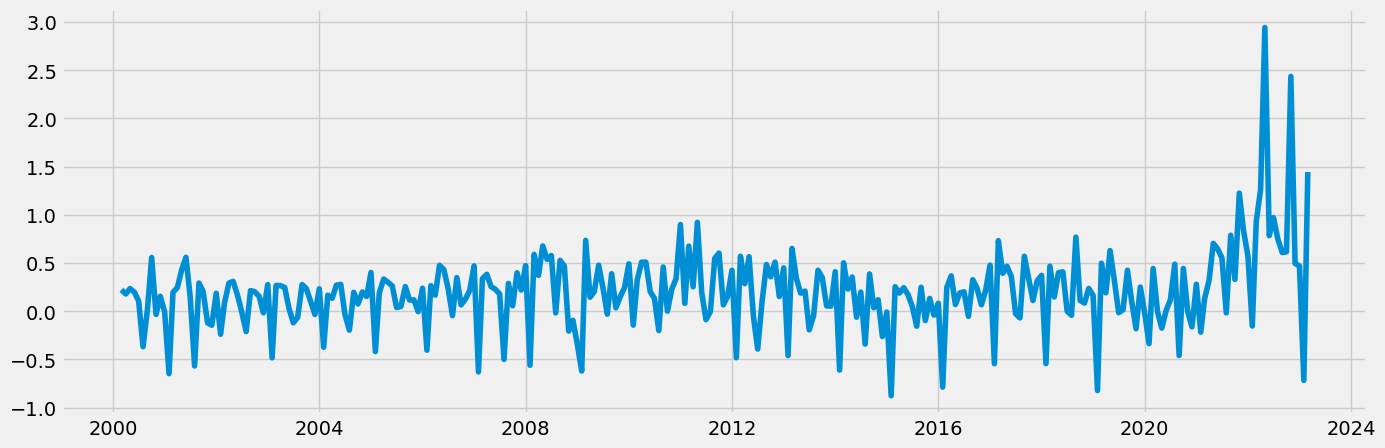

In [60]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [61]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -0.951476
p-value                          0.770549
Number of Lags Used             13.000000
Number of Observations Used    263.000000
Critical Value (1%)             -3.455461
Critical Value (5%)             -2.872593
Critical Value (10%)            -2.572660
dtype: float64


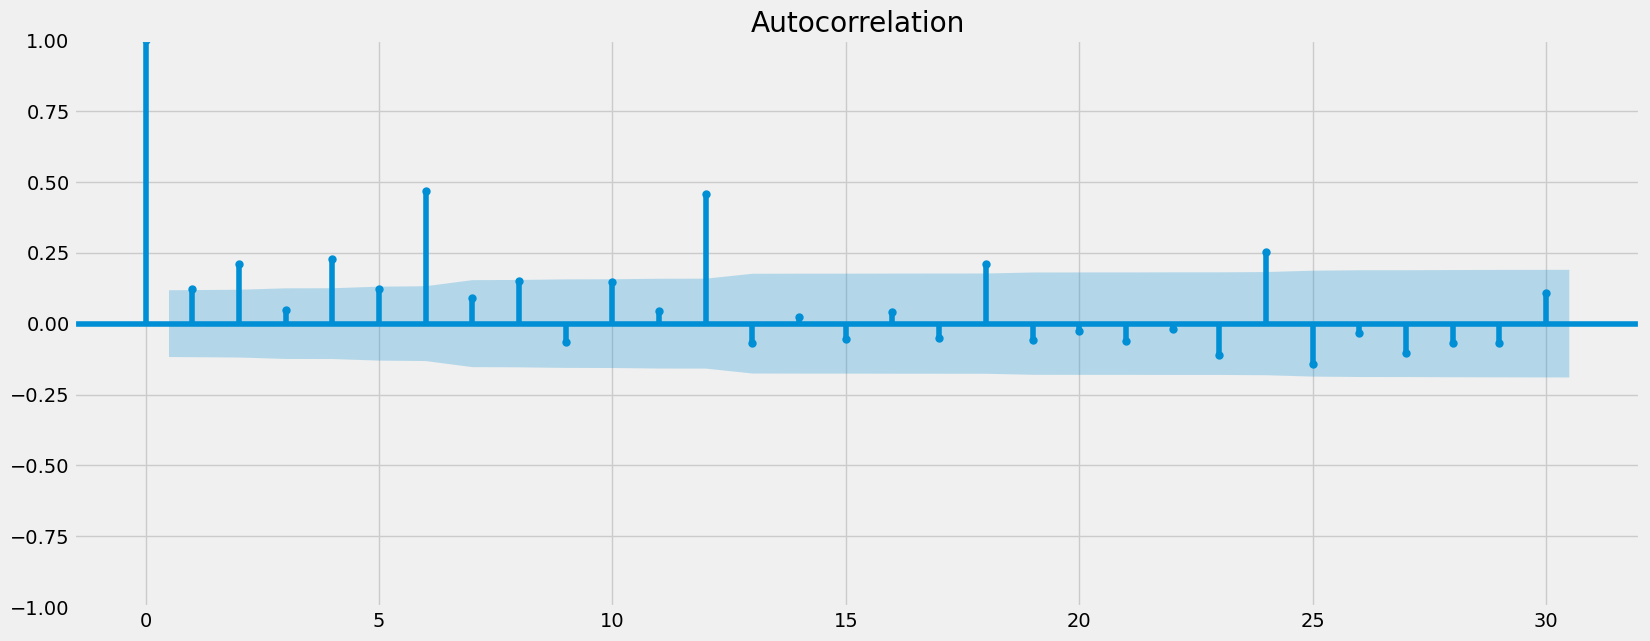

In [62]:
plot_acf(df_diff, lags=30)
plt.show()

Although the autocorrelation plot has improved, the data are still not stationary. As we can see, coeffient correlation is positive high at lag 1, 6,8 and 18-23 and negative high at 23 and 25. From this pattern, we could see that seasonality is present.
However, Dickey-Fuller Stationarity test shows that time-series is already stationary.